### New Idea

In [1]:
from abc import ABC, abstractmethod

import os
from tqdm import tqdm
import math 
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy import stats
from scipy.special import digamma

import torch
from torch.distributions import Beta, kl_divergence
from torch.nn.functional import log_softmax
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset

from bayes_opt import BayesianOptimization
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

In [2]:
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
### these params control the generation scheme (2/10 generation)
rho        = 0.8    # polarization
pop_size   = 10000  # num individuals
epsilon    = 0.05   # expected prop of speech consisting of neutral words
pi         = 0.5    # pi == 0.5 => beta mixture symmetrical (choose beta1 with prob pi = 0.5)
speech_len = 50     # words per speech
lex_size   = 3      # lexicon size 

In [4]:
def generate(rho=rho, N=pop_size, epsilon=epsilon, pi=pi, speech_len=speech_len, lex_size=lex_size, verbose='low'):
    """
    Uses 2/10 generation scheme to generate N samples.

    Returns:
        (X, y), (a, b, rho, epsilon, u, lex_size)
        X.size() == [N, S] is a vector of sequences 
        y.size() == [N] is a vector of political parties
        u.shape  == (N,) is a vector of individual stances
        rho is true polarization
        epsilon is expected prop of neutral words
        a, b are true alpha/beta for beta mixture model
    """
    start = time.time()
    if verbose in ['mid', 'high']:
        print(f'Beginning Data Generation...')
        print(f'=' * 20)
        
    ### get beta mixture model params 
    sigma = 0.175 * (rho ** 2) - 0.3625 * rho + 0.1875
    a     = rho * ((rho * (1 - rho)) / sigma - 1)
    b     = (1 - rho) * ((rho * (1 - rho)) / sigma - 1)

    if verbose in ['mid', 'high']:
        print(f'Lex Size: {lex_size}, Rho: {rho}, N: {pop_size}')
        print(f'epsilon: {epsilon}, pi: {pi}, S: {speech_len}\n')
        print(f"True Alpha: {a}")
        print(f"True Beta: {b}\n")

    mean = a / (a + b)
    var  = a * b / ((a + b)**2 * (a + b + 1))

    if abs(mean - rho) > 10e-15:
        print(f'Mean: {mean}')
        print(f"Rho: {rho}")
        raise AssertionError(f"Mean of BMM params should be rho")

    if abs(var - sigma) > 10e-15:
        print(f'Var: {var}')
        print(f'Sigma: {sigma}')
        raise AssertionError(f"Var of BMM params should be sigma")

    ### u ~ pi Beta(a, b) + (1 - pi) Beta(b, a)
    weights = [pi, 1-pi]
    mixture_samples = np.random.choice([0, 1], size=N, p=weights)

    u = 2 * np.where(mixture_samples == 1, stats.beta.rvs(a, b, size=N), stats.beta.rvs(b, a, size=N)) - 1

    if u.shape != (N,):
        raise AssertionError(f"u.shape should be (N,)")

    if verbose == 'high':
        print(f'mixture samples: {mixture_samples[:3]}')
        print(f'u samples: {u[:3]}')

    ### y = 1(u >= 0)
    y = (u >= 0).astype(int)

    if verbose == 'high':
        print(f'y samples: {y[:3]}\n')

    ### phi is a prob matrix that is a function of u, epsilon
    left_prob    = (1 - (u+1)/2) * (1 - epsilon) / lex_size
    right_prob   = (u+1)/2 * (1 - epsilon) / lex_size
    neutral_prob = np.repeat(epsilon, N) / lex_size
    phi          = np.array([left_prob] * lex_size + [right_prob] * lex_size + [neutral_prob] * lex_size).T
    
    if verbose == 'high':
        for i in range(3):
            print(f'P(L) = {phi[i,0]}, P(R): {phi[i, lex_size]}, P(N): {phi[i,-1]}')

    if phi.shape != (N, 3 * lex_size):
        raise AssertionError(f'phi.shape should be (N, V) == (N, 3L)')

    if abs(sum(phi[0]) - 1) > 10e-5:
        raise AssertionError(f'rows of phi should sum to 1')
    
    X = np.array([stats.multinomial.rvs(n=speech_len, p=phi[i, :]) for i in range(N)])

    if verbose == 'high':
        print(f'mixture samples: {mixture_samples[:3]}')
        print(f'u samples: {u[:3]}')

    ### y = 1(u >= 0)
    y = (u >= 0).astype(int)

    if verbose == 'high':
        print(f'y samples: {y[:3]}\n')

    ### phi is a prob matrix that is a function of u, epsilon
    left_prob    = (1 - (u+1)/2) * (1 - epsilon) / lex_size
    right_prob   = (u+1)/2 * (1 - epsilon) / lex_size
    neutral_prob = np.repeat(epsilon, N) / lex_size
    phi          = np.array([left_prob] * lex_size + [right_prob] * lex_size + [neutral_prob] * lex_size).T
    
    if verbose == 'high':
        for i in range(3):
            print(f'P(L) = {phi[i,0]}, P(R): {phi[i, lex_size]}, P(N): {phi[i,-1]}')

    if phi.shape != (N, 3 * lex_size):
        raise AssertionError(f'phi.shape should be (N, V) == (N, 3L)')

    if abs(sum(phi[0]) - 1) > 10e-5:
        raise AssertionError(f'rows of phi should sum to 1')
    
    X_voc = np.array([stats.multinomial.rvs(n=speech_len, p=phi[i, :]) for i in range(N)])

    if verbose == 'high':
        print(f'X samples (counts):\n {X_voc[:3]}\n')
    
    if X_voc.shape != (N, 3 * lex_size):
        raise AssertionError(f'X.shape should be (N, V) == (N, 3L)')

    if X_voc[:5].sum() != speech_len * 5:
        raise AssertionError(f'rows of phi should sum to 1')

    expanded_rows = []
    for row in X_voc:
        expanded_row = np.repeat(np.arange(len(row)), row)
        np.random.shuffle(expanded_row)
        expanded_rows.append(expanded_row)

    X_seq = np.array(expanded_rows, dtype=np.int64)

    if X_seq.shape != (N, speech_len):
        raise AssertionError(f'X.shape should be (N, S)')
    
    if verbose == 'high':
        print(f'X samples (sequences):\n {X_seq[:3]}\n')

    X_seq = torch.from_numpy(X_seq).to(torch.float32)
    y = torch.from_numpy(y).to(torch.float32)

    known   = (X_voc, X_seq, y)
    unknown = (a, b, rho, epsilon, u, lex_size)

    if verbose in ['mid', 'high']:
        print('=' * 20)
        print(f'Generation Time: {round(time.time() - start, 3)} seconds for {N} samples.')

    return known, unknown

known, unknown = generate(verbose='high', lex_size=3, N=50000, speech_len=100)
X_voc, X_seq, y = known
a, b, rho, epsilon, u, lex_size = unknown

Beginning Data Generation...
Lex Size: 3, Rho: 0.8, N: 10000
epsilon: 0.05, pi: 0.5, S: 100

True Alpha: 12.673684210526261
True Beta: 3.1684210526315644

mixture samples: [0 1 0]
u samples: [-0.71319006  0.57688516 -0.46523368]
y samples: [0 1 0]

P(L) = 0.2712550923688634, P(R): 0.04541157429780326, P(N): 0.016666666666666666
P(L) = 0.06699318292320035, P(R): 0.24967348374346632, P(N): 0.016666666666666666
P(L) = 0.23199533330535926, P(R): 0.08467133336130739, P(N): 0.016666666666666666
mixture samples: [0 1 0]
u samples: [-0.71319006  0.57688516 -0.46523368]
y samples: [0 1 0]

P(L) = 0.2712550923688634, P(R): 0.04541157429780326, P(N): 0.016666666666666666
P(L) = 0.06699318292320035, P(R): 0.24967348374346632, P(N): 0.016666666666666666
P(L) = 0.23199533330535926, P(R): 0.08467133336130739, P(N): 0.016666666666666666
X samples (counts):
 [[25 25 31  1  6  4  1  5  2]
 [ 5 10  6 23 21 30  4  1  0]
 [25 26 21  6  5 10  1  2  4]]

X samples (sequences):
 [[2 0 2 0 1 1 1 1 0 0 5 2 2 2 

This is stupid but we can find better

In [91]:
def generate_W(X_voc, y, normalize=True, max_val=1):
    y_np = y.numpy().ravel() 
    model = LogisticRegression(max_iter=7500)  # Adjust max_iter as needed
    model.fit(X_voc, y_np)
    coefficients = model.coef_[0]  
    max_coeff = np.max(np.abs(coefficients))
    normalized_coefficients = max_val * coefficients / max_coeff
    W = torch.tensor(normalized_coefficients, dtype=torch.float32)
    return W

W = generate_W(X_voc, y, max_val=1)

In [107]:
W

tensor([-0.2455, -0.2477, -0.2396,  0.2500,  0.2403,  0.2426, -0.0546,  0.0377,
        -0.0448])

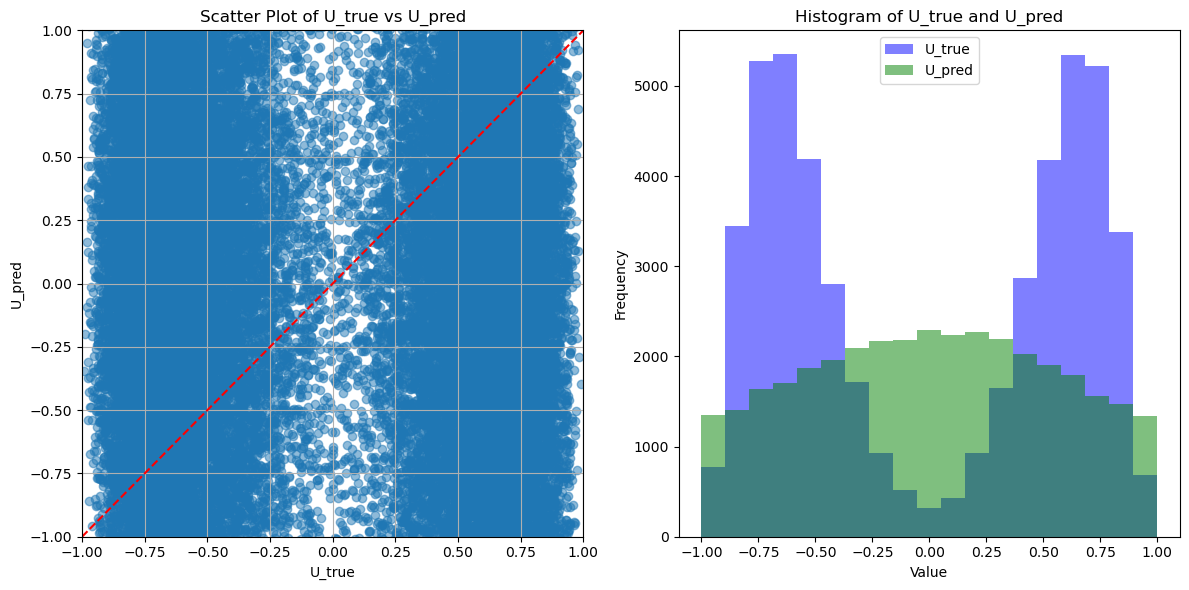

In [108]:
def visualize_u(U_pred, U_true):
    # Ensure that both U_pred and U_true are numpy arrays for easier handling
    U_pred = U_pred.numpy() if isinstance(U_pred, torch.Tensor) else U_pred
    U_true = U_true.numpy() if isinstance(U_true, torch.Tensor) else U_true
    
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Scatter plot to compare predictions vs true values
    axs[0].scatter(U_true, U_pred, alpha=0.5)
    axs[0].plot([-1, 1], [-1, 1], 'r--')  # Line y=x for reference
    axs[0].set_xlabel('U_true')
    axs[0].set_ylabel('U_pred')
    axs[0].set_title('Scatter Plot of U_true vs U_pred')
    axs[0].set_xlim([-1, 1])
    axs[0].set_ylim([-1, 1])
    axs[0].grid(True)
    
    # Histogram to compare the distributions
    bins = np.linspace(-1, 1, 20)  # Define bin edges
    axs[1].hist(U_true, bins, alpha=0.5, label='U_true', color='blue')
    axs[1].hist(U_pred, bins, alpha=0.5, label='U_pred', color='green')
    axs[1].set_title('Histogram of U_true and U_pred')
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

U_true = u
U_pred = U
visualize_u(U_pred, U_true)


In [93]:
import torch
import torch.optim as optim

def find_u(W, X_voc):
    """
    Function to find vector U minimizing the squared L2 norm of the difference between softmax(Wu) and X_norm.

    Args:
    W (torch.Tensor): The coefficient tensor of shape (S,) where S is the size of the vocabulary.
    X_voc (torch.Tensor): The raw word count matrix of shape (N, S).

    Returns:
    torch.Tensor: Vector U of shape (N,1) where each element minimizes the loss for corresponding X_norm[i].
    """
    # Device configuration for PyTorch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Normalize X_voc so that each row sums to 1
    X_sum = X_voc.sum(dim=1, keepdim=True)
    X_norm = X_voc / X_sum  # Normalized X_voc

    # Constants
    N, S = X_norm.shape  # Number of samples and vocabulary size

    # Initialize U with random values
    U = torch.randn(N, 1, device=device, requires_grad=True)

    # Define optimizer
    optimizer = optim.Adam([U], lr=0.01)  # Learning rate can be adjusted

    # Number of epochs for optimization
    num_epochs = 1000  # Adjust number of epochs as necessary

    # Optimization loop
    for _ in range(num_epochs):
        optimizer.zero_grad()  # Reset gradients

        # Calculate predicted softmax
        Wu = torch.matmul(U, W.view(1, -1))  # Transform U by W
        predictions = torch.softmax(Wu, dim=1)  # Apply softmax

        # Calculate loss
        loss = torch.sum((predictions - X_norm))  # Squared L2 norm

        # Backpropagation
        loss.backward()  # Compute gradients
        optimizer.step()  # Update U

    return U.detach()  # Return U without gradient tracking

# Example usage
# W should be a torch tensor of the form [S] (converted from the normalized coefficients)
# X_voc should be a numpy array or a torch tensor
X_voc_tensor = torch.tensor(X_voc, dtype=torch.float32)  # If not already a tensor
W_tensor = W  # Assuming W is already a torch tensor from the previous code

U = find_u(W_tensor, X_voc_tensor)


In [79]:
import torch
import torch.optim as optim

def find_u_transformed(W, X_voc, y):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Normalize X_voc
    X_sum = X_voc.sum(dim=1, keepdim=True)
    X_norm = X_voc / X_sum

    # Initialize v with random values
    N = X_norm.shape[0]
    v = torch.randn(N, device=device, requires_grad=True)

    # Define optimizer
    optimizer = optim.Adam([v], lr=0.01)

    num_epochs = 1000  # Adjust number of epochs as necessary

    for _ in range(num_epochs):
        optimizer.zero_grad()

        # Apply transformation based on y
        U = torch.where(y == 1, torch.sigmoid(v), -1 + torch.sigmoid(v))

        # Calculate predicted softmax
        Wu = torch.matmul(U.unsqueeze(1), W.unsqueeze(0))  # Ensure correct shape [N, 1] * [1, V] = [N, V]
        predictions = torch.softmax(Wu, dim=1)

        # Calculate loss
        loss = torch.sum((predictions - X_norm) ** 2)

        loss.backward()
        optimizer.step()

    # Apply final transformation to ensure constraints are respected
    U_final = torch.where(y == 1, torch.sigmoid(v), -1 + torch.sigmoid(v))
    return U_final.detach()

# Example usage
W_tensor = W  # W should already be a tensor from the previous code of shape [V]
X_voc_tensor = torch.tensor(X_voc, dtype=torch.float32)
y_tensor = y  # Assuming y is already a torch tensor of shape [N]

U = find_u_transformed(W_tensor, X_voc_tensor, y_tensor)
